In [538]:
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns

In [539]:
df=pd.read_csv('market_pipe_thickness_loss_dataset.csv')

Conozcamos los datos

In [540]:
df.head()

,Pipe_Size_mm,Thickness_mm,Material,Grade,Max_Pressure_psi,Temperature_C,Corrosion_Impact_Percent,Thickness_Loss_mm,Material_Loss_Percent,Time_Years,Condition
0,800,15.48,Carbon Steel,ASTM A333 Grade 6,300,84.9,16.04,4.91,31.72,2,Moderate
1,800,22.00,PVC,ASTM A106 Grade B,150,14.1,7.38,7.32,33.27,4,Critical
2,400,12.05,Carbon Steel,API 5L X52,2500,0.6,2.12,6.32,52.45,7,Critical
3,1500,38.72,Carbon Steel,API 5L X42,1500,52.7,5.58,6.20,16.01,19,Critical
4,1500,24.32,HDPE,API 5L X65,1500,11.7,12.29,8.58,35.28,20,Critical


In [541]:
df.columns

Index(['Pipe_Size_mm', 'Thickness_mm', 'Material', 'Grade', 'Max_Pressure_psi',
       'Temperature_C', 'Corrosion_Impact_Percent', 'Thickness_Loss_mm',
       'Material_Loss_Percent', 'Time_Years', 'Condition'],
      dtype='object')

In [542]:
df.isna().sum()

Pipe_Size_mm                0
Thickness_mm                0
Material                    0
Grade                       0
Max_Pressure_psi            0
Temperature_C               0
Corrosion_Impact_Percent    0
Thickness_Loss_mm           0
Material_Loss_Percent       0
Time_Years                  0
Condition                   0
dtype: int64

In [543]:
#Creamos columna con valores 1 y 0 indicando si la tuberia necesita mantenimiento o no
df['Mantenimiento_Necesario'] = np.where(df['Condition'] == 'Critical',1,0)


In [544]:
df.head()

,Pipe_Size_mm,Thickness_mm,Material,Grade,Max_Pressure_psi,Temperature_C,Corrosion_Impact_Percent,Thickness_Loss_mm,Material_Loss_Percent,Time_Years,Condition,Mantenimiento_Necesario
0,800,15.48,Carbon Steel,ASTM A333 Grade 6,300,84.9,16.04,4.91,31.72,2,Moderate,0
1,800,22.00,PVC,ASTM A106 Grade B,150,14.1,7.38,7.32,33.27,4,Critical,1
2,400,12.05,Carbon Steel,API 5L X52,2500,0.6,2.12,6.32,52.45,7,Critical,1
3,1500,38.72,Carbon Steel,API 5L X42,1500,52.7,5.58,6.20,16.01,19,Critical,1
4,1500,24.32,HDPE,API 5L X65,1500,11.7,12.29,8.58,35.28,20,Critical,1


In [545]:
df['Mantenimiento_Necesario'].value_counts()
#Tenemos 487 valores que necesitan mantenimiento urgente

Mantenimiento_Necesario
0    513
1    487
Name: count, dtype: int64

In [546]:
#Analicemos que valores encontramos usualmente en las tuberias con valores criticos
promedios_criticos = df[df['Mantenimiento_Necesario'] == 1 ].mean(numeric_only=True)
print(promedios_criticos)

Pipe_Size_mm                 557.494867
Thickness_mm                  16.736694
Max_Pressure_psi            1004.414784
Temperature_C                 43.252567
Corrosion_Impact_Percent       9.794702
Thickness_Loss_mm              7.458172
Material_Loss_Percent         70.153018
Time_Years                    12.792608
Mantenimiento_Necesario        1.000000
dtype: float64


In [547]:
#Anteriormente obtuvimos una precision del 100% con los siguientes datos:
#Thickness_mm =Espesor inicial en mm
#max_pressure_psi=Maxima presion registrada en la tuberia en psi
#Corrosion_Impact_Percent=porcentaje estimado de impacto por corrosion medido
#Thickness_Loss_mm=Espesor perdido de pared en mm por corrosion
#Time_Years=Años en servicio de la tuberia

Veamos nuevamente estos datos

Text(0, 0.5, 'Espesor perdido de pared(mm)')

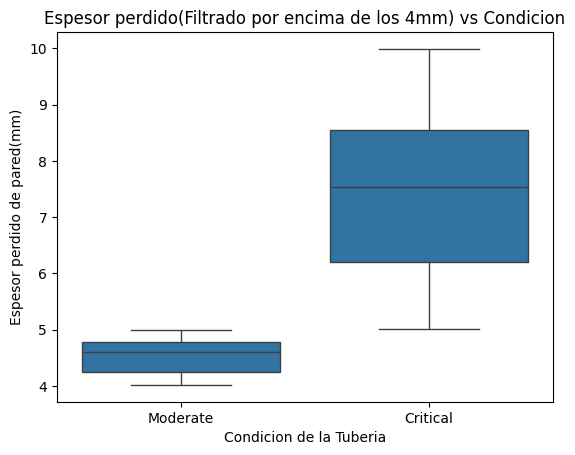

In [548]:
sns.boxplot(data=df[df['Thickness_Loss_mm']>4],x='Condition',y='Thickness_Loss_mm')
plt.title("Espesor perdido(Filtrado por encima de los 4mm) vs Condicion")
plt.xlabel('Condicion de la Tuberia')
plt.ylabel('Espesor perdido de pared(mm)')

In [549]:
#Podemos ver que nuestras tuberias llegan a estado critico
#cuando la perdida de espesor esta por encima de los 6mm

Veamos como se ve la perdida de espesor durante los años 

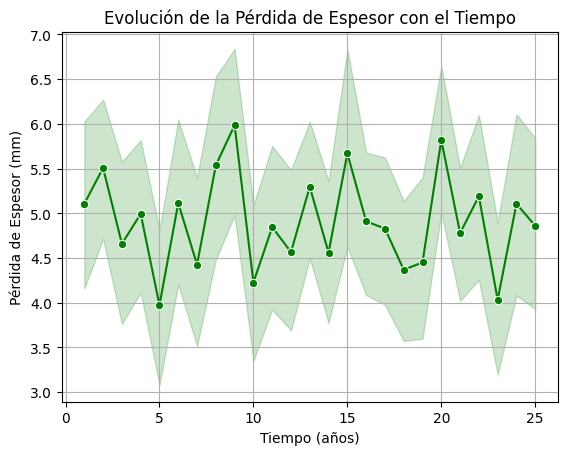

In [550]:
sns.lineplot(data=df, x="Time_Years", y="Thickness_Loss_mm", marker="o", color="green")

plt.title("Evolución de la Pérdida de Espesor con el Tiempo")
plt.xlabel("Tiempo (años)")
plt.ylabel("Pérdida de Espesor (mm)")
plt.grid(True)
plt.show()

Analizamos como actua la corrosión con el tiempo. Este es un factor que influye mucho en el deterioro de nuestras tuberias

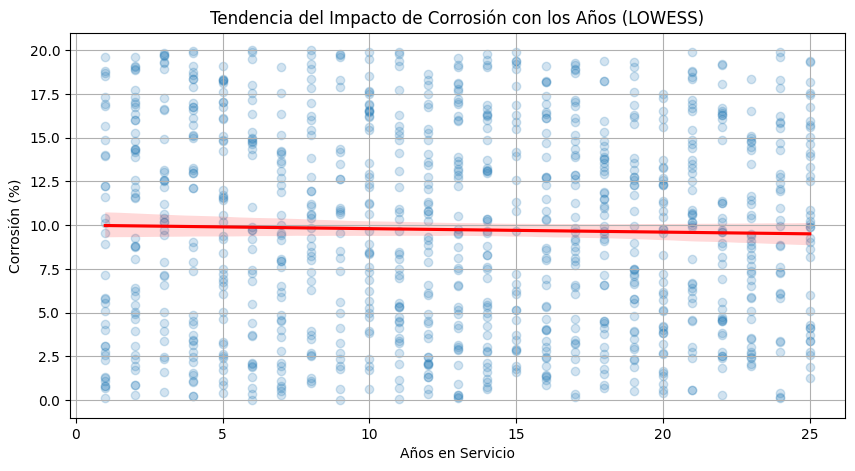

In [551]:
plt.figure(figsize=(10,5))
sns.regplot(data=df, x="Time_Years", y="Corrosion_Impact_Percent",  scatter_kws={'alpha':0.2}, line_kws={'color':'red'})
plt.title("Tendencia del Impacto de Corrosión con los Años (LOWESS)")
plt.xlabel("Años en Servicio")
plt.ylabel("Corrosión (%)")
plt.grid(True)
plt.show()
#Podemos ver que la corrosion desacelera en el paso del tiempo

En este modelo busco añadir una mejora que es indicar cuanto tiempo le queda a las tuberias en condicion normal y moderada hasta llegar a condicion critica

In [552]:
# Parámetro asumido para pérdida máxima de espesor
L_inf_default = 6.5 # mm

#Creamos una funcion para calcular el tiempo restante  (Modelo Exponencial)
#La funcion es modelo exponencial ya que anteriormente vimos que nuestra corrosión actua de manera decreciente 
def calcular_tiempo_restante(row, L_critico=6.0, L_inf=6.5):
    if row['Condition'] not in ['Normal', 'Moderate']:
        return np.nan  # no calcular si es ya "crítica"

    L_actual = row['Thickness_Loss_mm']
    t_actual = row['Time_Years']

    # Verificamos que L_actual es menor a nuestro parametro (perdida maxima de espesor)
    if L_actual >= L_inf_default:
        return 0.0

    try:
        k = -np.log(1 - (L_actual / L_inf)) / t_actual
        if k <= 0:
            return np.nan  # evita valores inválidos
        t_critico = -np.log(1 - (L_critico / L_inf)) / k
        tiempo_restante = t_critico - t_actual
        return max(tiempo_restante, 0)  # no valores negativos
    except Exception:
        return np.nan  # para evitar errores con logs negativos o cero

# Aplicar la función
df['Tiempo_Restante_Critico'] = df.apply(calcular_tiempo_restante, axis=1)


In [553]:
df['Presión_específica'] =df[ 'Max_Pressure_psi'] / df['Thickness_mm']

In [554]:
df['Tasa_Corrosión'] = df['Thickness_Loss_mm']/ df['Time_Years']

In [555]:
df.head()

,Pipe_Size_mm,Thickness_mm,Material,Grade,Max_Pressure_psi,Temperature_C,Corrosion_Impact_Percent,Thickness_Loss_mm,Material_Loss_Percent,Time_Years,Condition,Mantenimiento_Necesario,Tiempo_Restante_Critico,Presión_específica,Tasa_Corrosión
0,800,15.48,Carbon Steel,ASTM A333 Grade 6,300,84.9,16.04,4.91,31.72,2,Moderate,0,1.643218,19.379845,2.455000
1,800,22.00,PVC,ASTM A106 Grade B,150,14.1,7.38,7.32,33.27,4,Critical,1,NaN,6.818182,1.830000
2,400,12.05,Carbon Steel,API 5L X52,2500,0.6,2.12,6.32,52.45,7,Critical,1,NaN,207.468880,0.902857
3,1500,38.72,Carbon Steel,API 5L X42,1500,52.7,5.58,6.20,16.01,19,Critical,1,NaN,38.739669,0.326316
4,1500,24.32,HDPE,API 5L X65,1500,11.7,12.29,8.58,35.28,20,Critical,1,NaN,61.677632,0.429000


In [556]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


Creemos un nuevo dataframe con nuestros datos a analizar

In [557]:
df.columns

Index(['Pipe_Size_mm', 'Thickness_mm', 'Material', 'Grade', 'Max_Pressure_psi',
       'Temperature_C', 'Corrosion_Impact_Percent', 'Thickness_Loss_mm',
       'Material_Loss_Percent', 'Time_Years', 'Condition',
       'Mantenimiento_Necesario', 'Tiempo_Restante_Critico',
       'Presión_específica', 'Tasa_Corrosión'],
      dtype='object')

In [558]:
df_model=df.drop([ 'Material', 'Grade','Temperature_C','Pipe_Size_mm','Material_Loss_Percent'],axis=1)

In [559]:
df_model.head()

,Thickness_mm,Max_Pressure_psi,Corrosion_Impact_Percent,Thickness_Loss_mm,Time_Years,Condition,Mantenimiento_Necesario,Tiempo_Restante_Critico,Presión_específica,Tasa_Corrosión
0,15.48,300,16.04,4.91,2,Moderate,0,1.643218,19.379845,2.455000
1,22.00,150,7.38,7.32,4,Critical,1,NaN,6.818182,1.830000
2,12.05,2500,2.12,6.32,7,Critical,1,NaN,207.468880,0.902857
3,38.72,1500,5.58,6.20,19,Critical,1,NaN,38.739669,0.326316
4,24.32,1500,12.29,8.58,20,Critical,1,NaN,61.677632,0.429000


In [560]:
features=['Thickness_mm', 'Max_Pressure_psi', 'Corrosion_Impact_Percent',
       'Thickness_Loss_mm', 'Time_Years','Tasa_Corrosión','Presión_específica']

Creamos un arbol de decision de clasificacion

In [561]:
X = df_model.drop(columns=['Condition', 'Mantenimiento_Necesario', 'Tiempo_Restante_Critico'])
y = df_model['Mantenimiento_Necesario']

In [562]:
# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [563]:

# Creamos y entrenamos el clasificador
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [564]:
# Predecimos y luego evaluamos 
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       112
           1       1.00      1.00      1.00        88

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [565]:
#Nuestro modelo tiene la precision de un 100%
#para tuberias en condicion critica(Necesitan cambio urgente)

Arbol de decision de regresion

In [566]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


In [567]:
# Filtrar datos donde mantenimiento es 0 (no crítico)
df_reg = df_model[(df_model['Mantenimiento_Necesario'] == 0) & (df_model['Tiempo_Restante_Critico'].notna())&(df_model['Thickness_Loss_mm']<6.5)]

In [568]:
X_reg = df_reg.drop(columns=['Mantenimiento_Necesario', 'Condition','Tiempo_Restante_Critico']) 
y_reg = np.log1p(df_reg['Tiempo_Restante_Critico'])

In [569]:
preprocesador=ColumnTransformer(
    transformers=[
        ("feat",StandardScaler(),features),
      
    ],
    remainder="drop"
)

In [570]:
pipeline = Pipeline(steps=[
    ("preprocessor", preprocesador),
    ('regressor',DecisionTreeRegressor(random_state=42)),

])

In [571]:
# Dividir en entrenamiento y prueba
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42)

In [572]:
pipeline.fit(X_train_reg,y_train_reg)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('feat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [573]:
y_pred_reg=pipeline.predict(X_test_reg)

In [574]:
mae = mean_absolute_error(y_test_reg, y_pred_reg)
mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_reg, y_pred_reg)

In [575]:
print(f"MAE (Error absoluto medio): {mae:.2f}")
print(f"MSE (Error cuadrático medio): {mse:.2f}")
print(f"RMSE (Raíz del error cuadrático medio): {rmse:.2f}")
print(f"R² (Coeficiente de determinación): {r2:.2f}")

MAE (Error absoluto medio): 0.10
MSE (Error cuadrático medio): 0.02
RMSE (Raíz del error cuadrático medio): 0.16
R² (Coeficiente de determinación): 0.99


Obtuvimos una precision del 96% en la prediccion

In [576]:
pipeline.score(X_test_reg,y_test_reg)*100

99.05658408250349

Validación cruzada

In [577]:
from sklearn.model_selection import cross_validate

In [592]:
result=cross_validate(clf,X,y,cv=6,
                      scoring=['accuracy','precision','recall','f1'])

In [593]:
print("Accuracy promedio:", result['test_accuracy'].mean()*100)
print("Precision promedio:", result['test_precision'].mean()*100)
print("Recall promedio:", result['test_recall'].mean()*100)
print("F1-score promedio:", result['test_f1'].mean()*100)

Accuracy promedio: 100.0
Precision promedio: 100.0
Recall promedio: 100.0
F1-score promedio: 100.0


In [594]:
result2=cross_validate(pipeline,X,y,cv=6,
                      scoring=['accuracy','precision','recall','f1'])

In [595]:
print("Accuracy promedio:", result2['test_accuracy'].mean()*100)
print("Precision promedio:", result2['test_precision'].mean()*100)
print("Recall promedio:", result2['test_recall'].mean()*100)
print("F1-score promedio:", result2['test_f1'].mean()*100)

Accuracy promedio: 100.0
Precision promedio: 100.0
Recall promedio: 100.0
F1-score promedio: 100.0


In [580]:
import joblib

In [581]:
joblib.dump(clf,"modelo_clasificacion.pkl")

['modelo_clasificacion.pkl']

In [582]:
joblib.dump(pipeline,'modelo_regresion.pkl')

['modelo_regresion.pkl']